In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [2]:
RANDOM_STATE = 42

# -----------------------------
# 1. Load and clean data
# -----------------------------

df = pd.read_csv("../data/TCR-A3_CDR3b-t4x_MAGE-A3_specificity.csv")

# Keep only confident labels
df = df[df["specificity"].isin([0, 1])].reset_index(drop=True)

# Check fixed-length CDR3β
cdr3_lengths = df["cdr3"].str.len().unique()
if len(cdr3_lengths) != 1:
    raise ValueError("All CDR3β sequences must have the same length")

cdr3_len = cdr3_lengths[0]
print(f"CDR3β length: {cdr3_len}")

CDR3β length: 13


In [3]:
# -----------------------------
# 2. Position-wise encoding
# -----------------------------

def explode_cdr3(df, column="cdr3", prefix="pos"):
    return pd.DataFrame(
        df[column].apply(list).tolist(),
        columns=[f"{prefix}_{i}" for i in range(df[column].str.len().iloc[0])]
    )

X_df = explode_cdr3(df)
y = df["specificity"].values

display(X_df, y)

,pos_0,pos_1,pos_2,pos_3,pos_4,pos_5,pos_6,pos_7,pos_8,pos_9,pos_10,pos_11,pos_12
0,C,A,A,A,A,S,M,A,D,E,Q,Y,F
1,C,A,A,A,C,Q,M,A,D,E,Q,Y,F
2,C,A,A,A,G,G,M,A,D,E,Q,Y,F
3,C,A,A,A,L,S,M,A,D,E,Q,Y,F
4,C,A,A,A,N,N,M,A,D,E,Q,Y,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25487,C,Y,W,L,V,N,M,A,D,E,Q,Y,F
25488,C,Y,Y,G,I,N,M,A,D,E,Q,Y,F
25489,C,Y,Y,G,L,N,M,A,D,E,Q,Y,F
25490,C,Y,Y,H,V,N,M,A,D,E,Q,Y,F


array([0, 0, 0, ..., 0, 0, 1])

In [4]:
np.unique(y, return_counts=True)

(array([0, 1]), array([24070,  1422]))

In [5]:
# -----------------------------
# 3. Train/test split
# -----------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X_df,
    y,
    test_size=0.25,
    stratify=y,
    random_state=RANDOM_STATE
)

In [6]:
# One-hot encoder
ohe = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=True
)

In [7]:
models = {
    "Logistic Regression": Pipeline([
        ("ohe", ohe),
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", LogisticRegression(
            max_iter=1000,
            n_jobs=-1
        ))
    ]),
    "SVM (RBF)": Pipeline([
        ("ohe", ohe),
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", SVC(
            kernel="rbf",
            probability=True
        ))
    ]),
    "Random Forest": Pipeline([
        ("ohe", ohe),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])
}

In [8]:
# -----------------------------
# 5. Train + evaluate
# -----------------------------

results = []
roc_data = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUROC": roc_auc_score(y_test, y_prob)
    }

    results.append(metrics)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_data[name] = (fpr, tpr, metrics["AUROC"])

results_df = pd.DataFrame(results)

Training Logistic Regression...
Training SVM (RBF)...
Training Random Forest...


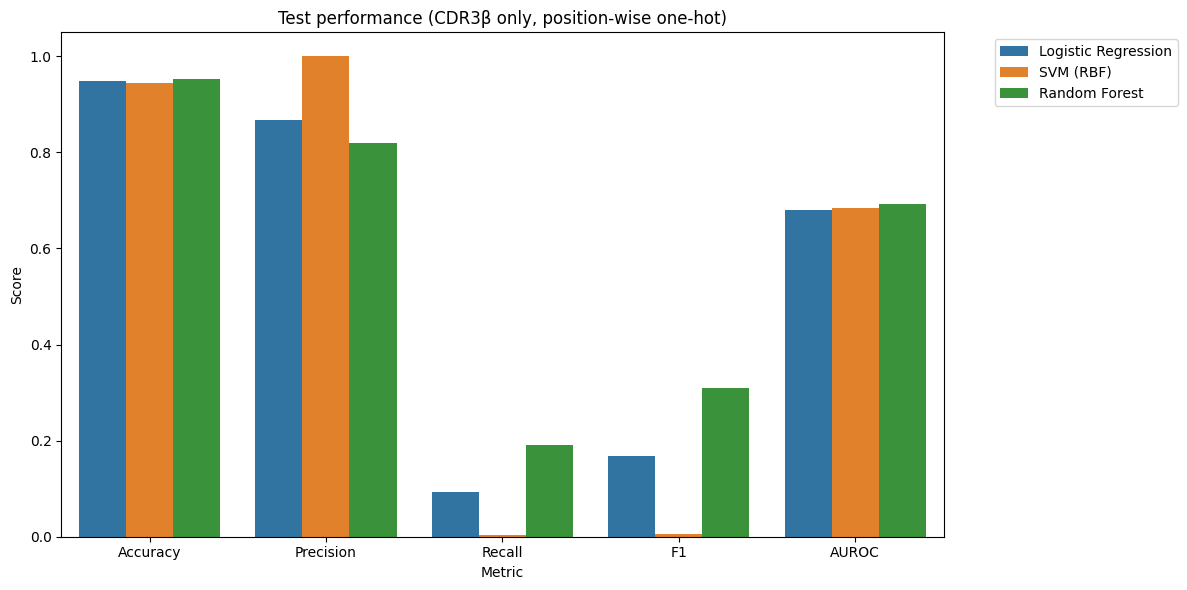

In [9]:
# -----------------------------
# 6. Metric bar plots
# -----------------------------

metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1", "AUROC"]

results_long = results_df.melt(
    id_vars="Model",
    value_vars=metrics_to_plot,
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_long,
    x="Metric",
    y="Score",
    hue="Model"
)
plt.ylim(0, 1.05)
plt.title("Test performance (CDR3β only, position-wise one-hot)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

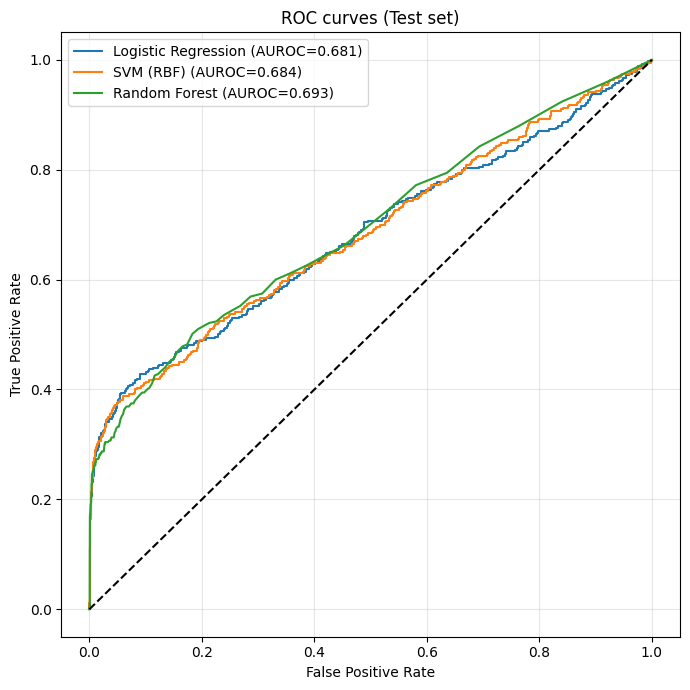

In [10]:
# -----------------------------
# 7. ROC curves
# -----------------------------

plt.figure(figsize=(7, 7))

for name, (fpr, tpr, auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUROC={auc:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves (Test set)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
# -----------------------------
# 8. Print summary table
# -----------------------------

print("\nTest-set performance summary:")
print(results_df.round(3))



Test-set performance summary:
                 Model  Accuracy  Precision  Recall     F1  AUROC
0  Logistic Regression     0.949      0.868   0.093  0.168  0.681
1            SVM (RBF)     0.944      1.000   0.003  0.006  0.684
2        Random Forest     0.953      0.819   0.192  0.311  0.693


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

RANDOM_STATE = 42

In [2]:
# -----------------------------
# 1. Load and clean data
# -----------------------------
df = pd.read_csv("../data/TCR-A3_CDR3b-t4x_MAGE-A3_specificity.csv")
df = df[df["specificity"].isin([0, 1])].reset_index(drop=True)

cdr3_lengths = df["cdr3"].str.len().unique()
if len(cdr3_lengths) != 1:
    raise ValueError("All CDR3β sequences must have the same length")
cdr3_len = cdr3_lengths[0]
print(f"CDR3β length: {cdr3_len}")

NameError: name 'pd' is not defined

In [15]:
# -----------------------------
# 2. Position-wise one-hot encoding
# -----------------------------
def explode_cdr3(df, column="cdr3", prefix="pos"):
    return pd.DataFrame(df[column].apply(list).tolist(),
                        columns=[f"{prefix}_{i}" for i in range(df[column].str.len().iloc[0])])

X_df = explode_cdr3(df)
y = df["specificity"].values

X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)


In [17]:
# -----------------------------
# 3. Define Laplace kernel
# -----------------------------
def laplace_kernel(X, Y, sigma=1.0):
    X = X.toarray() if hasattr(X, "toarray") else X
    Y = Y.toarray() if hasattr(Y, "toarray") else Y
    pairwise_l1 = np.sum(np.abs(X[:, None, :] - Y[None, :, :]), axis=2)
    return np.exp(-pairwise_l1 / sigma)

In [18]:
# -----------------------------
# 4. SVM kernel comparison
# -----------------------------
svm_models = {
    "SVM Linear": Pipeline([
        ("ohe", ohe),
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", SVC(kernel="linear", probability=True))
    ]),
    "SVM RBF": Pipeline([
        ("ohe", ohe),
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", SVC(kernel="rbf", probability=True))
    ]),
    "SVM Laplace": Pipeline([
        ("ohe", ohe),
        ("clf", SVC(kernel=laplace_kernel, probability=True))
    ])
}

svm_results = []
svm_roc = {}

for name, model in svm_models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUROC": roc_auc_score(y_test, y_prob)
    }
    svm_results.append(metrics)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    svm_roc[name] = (fpr, tpr, metrics["AUROC"])

svm_df = pd.DataFrame(svm_results)
print("\nSVM kernel comparison:")
print(svm_df.round(3))

# Pick the best SVM (highest AUROC)
best_svm_name = svm_df.sort_values("AUROC", ascending=False)["Model"].iloc[0]
print(f"\nBest SVM kernel: {best_svm_name}")

Training SVM Linear...


/cluster/project/reddy/marluca/NGS_pipeline/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training SVM RBF...
Training SVM Laplace...


In [1]:
# -----------------------------
# 5. Compare best SVM vs LR & RF
# -----------------------------
comparison_models = {
    best_svm_name: svm_models[best_svm_name],
    "Logistic Regression": Pipeline([
        ("ohe", ohe),
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", LogisticRegression(max_iter=1000, n_jobs=-1))
    ]),
    "Random Forest": Pipeline([
        ("ohe", ohe),
        ("clf", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1))
    ])
}

results = []
roc_data = {}

for name, model in comparison_models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUROC": roc_auc_score(y_test, y_prob)
    }
    results.append(metrics)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_data[name] = (fpr, tpr, metrics["AUROC"])

results_df = pd.DataFrame(results)

NameError: name 'best_svm_name' is not defined